In [1]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

Using TensorFlow backend.


GeForce GTX 1070 Ti


# CRISP-DM step 1:   Business Understanding

I chose the Airbnb dataset.  I didn't want to get bogged down trying to explain something abstract, and a basic understanding of property rental is pretty universal.  Most people have paid rent at some point in their life.

## Questions:

1. Who are the potential customers?  (demographics)
2. What is the purpose of their rental?  (vacation, business trip, temporary work)
3. What duration of rental are they looking for?
4. Which locations are most popular?
5. What type of accomodation are they looking for?  (size, occupancy, amenities)
6. Which locations/types of properties bring in the largest rent?

# CRISP-DM step 2:  Data Understanding

Quick 'n dirty data inspection.  There's nothing too surprising here, it just takes a lot of vertical space.  (Unfortunately Jupyter does not have a 'collapse cells' feature.)

I actually did several passes on this section to keep it as compact as possible, first rejecting tables, and then throwing out columns.  What you see here has been cleaned up for the benefit of the grader.

In [2]:
import pandas as pd

The 'neighborhoods' and 'neighborhoods.geojson' are a little curious.  The 'neighborhood' column seems to be the primary key in the 'neighborhoods' table, which apparently lines up row-wise with the entries in the 'neighbourhoods.geojson' file.  (That's a guess, these could have been put in a single table.)

Both neighborhood and geolocation are included in the 'listings' table, so there is some redundancy in this data.  We don't actually need to draw a map of the neighborhoods in this projects, so these two tables can be safely discarded.

In [3]:
df_b_neighbourhoods = pd.read_csv('Boston/neighbourhoods.csv')
df_b_neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,NaN,Allston
1,NaN,Back Bay
2,NaN,Bay Village
3,NaN,Beacon Hill
4,NaN,Brighton


In [4]:
df_b_neighbourhoods = pd.read_json('Boston/neighbourhoods.geojson')
df_b_neighbourhoods.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."


The 'reviews' table would be of interest for sentiment analysis, which again is beyond the scope of this project.

'reviews' looks like a dimension table but surprisingly, it does not contain numerical review scores. These are found in the 'listings' table instead, which should suffice for our purposes.

In [5]:
# reviews.csv is a subset of reviews.csv.gz, so it can be ignored
df_b_reviews = pd.read_csv('Boston/reviews.csv.gz')
df_b_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3781,37776825,2015-07-10,36059247,Greg,The apartment was as advertised and Frank was ...
1,3781,41842494,2015-08-09,10459388,Tai,It was a pleasure to stay at Frank's place. Th...
2,3781,45282151,2015-09-01,12264652,Damien,The apartment description is entirely faithful...
3,3781,49022647,2015-09-30,41426327,Mike,Thoroughly enjoyed my time at Frank's home. Ha...
4,3781,52503327,2015-10-30,15151513,Ivan,Great value for the money! This location has e...


The 'calendar' table sounds like it might be useful for looking at seasonal history.  However, it seems to be more about future booking than rental history.  We'll give it a look and put it on the shelf for now...

In [6]:
df_b_calendar = pd.read_csv('Boston/calendar.csv.gz')
df_b_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,50032,2019-01-17,f,$538.00,$538.00,3,365
1,50032,2019-01-18,f,$550.00,$550.00,3,365
2,50032,2019-01-19,f,$562.00,$562.00,3,365
3,50032,2019-01-20,f,$575.00,$575.00,3,365
4,50032,2019-01-21,f,$588.00,$588.00,3,365


In [7]:
df_b_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280155 entries, 0 to 2280154
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 121.8+ MB


In [8]:
df_b_calendar.nunique()

listing_id        6247
date               365
available            2
price             2172
adjusted_price    2171
minimum_nights      48
maximum_nights     142
dtype: int64

In [9]:
df_b_calendar.hist(layout=(1,3), figsize=(12,3));

In [10]:
df_b_calendar.describe()

,listing_id,minimum_nights,maximum_nights
count,2.280155e+06,2.280155e+06,2.280155e+06
mean,1.862067e+07,6.700191e+00,1.674891e+04
std,8.747444e+06,3.992715e+01,1.265104e+06
min,3.781000e+03,1.000000e+00,1.000000e+00
25%,1.256606e+07,1.000000e+00,1.090000e+02
50%,2.028121e+07,2.000000e+00,1.125000e+03
75%,2.580413e+07,3.000000e+00,1.125000e+03
max,3.162409e+07,9.990000e+02,1.000000e+08


It seems that any data pertinent to these questions exists in the 'listings' table.

In [11]:
df_b_listings = pd.read_csv('Boston/listings.csv.gz')
df_s_listings = pd.read_csv('Seattle/listings.csv.gz')
df_b_listings.head()

C:\Users\PaulW\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20190117205200,2019-01-17,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,This is a totally separate apartment located o...,Fully separate apartment in a two apartment bu...,none,"Mostly quiet ( no loud music, no crowed sidewa...",...,f,f,super_strict_30,f,f,1,1,0,0,0.33
1,5506,https://www.airbnb.com/rooms/5506,20190117205200,2019-01-17,**$79 Special ** Private! Minutes to center!,This is a private guest room with private bath...,**THE BEST Value in BOSTON!!*** PRIVATE GUEST ...,This is a private guest room with private bath...,none,"Peacful, Architecturally interesting, historic...",...,t,f,strict_14_with_grace_period,f,f,6,6,0,0,0.67
2,6695,https://www.airbnb.com/rooms/6695,20190117205200,2019-01-17,$99 Special!! Home Away! Condo,NaN,** WELCOME *** FULL PRIVATE APARTMENT In a His...,** WELCOME *** FULL PRIVATE APARTMENT In a His...,none,"Peaceful, Architecturally interesting, histori...",...,t,f,strict_14_with_grace_period,f,f,6,6,0,0,0.74
3,6976,https://www.airbnb.com/rooms/6976,20190117205200,2019-01-17,Mexican Folk Art Haven in Boston Residential Area,Come stay with me in Boston's Roslindale neigh...,"This is a well-maintained, two-family house bu...",Come stay with me in Boston's Roslindale neigh...,none,The LOCATION: Roslindale is a safe and diverse...,...,f,f,moderate,t,f,1,0,1,0,0.65
4,8789,https://www.airbnb.com/rooms/8789,20190117205200,2019-01-17,Curved Glass Studio/1bd facing Park,"Bright, 1 bed with curved glass windows facing...",Fully Furnished studio with enclosed bedroom. ...,"Bright, 1 bed with curved glass windows facing...",none,Beacon Hill is a historic neighborhood filled ...,...,f,f,strict_14_with_grace_period,f,f,10,10,0,0,0.41


In [12]:
df_b_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6247 entries, 0 to 6246
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(23), object(60)
memory usage: 5.1+ MB


In [13]:
df_b_listings.nunique()

id                                              6247
listing_url                                     6247
scrape_id                                          1
last_scraped                                       1
name                                            6002
summary                                         4938
space                                           3534
description                                     5381
experiences_offered                                1
neighborhood_overview                           2616
notes                                           2276
transit                                         2829
access                                          2606
interaction                                     2397
house_rules                                     2683
thumbnail_url                                      0
medium_url                                         0
picture_url                                     6088
xl_picture_url                                

# CRISP-DM step 3: Prepare the Data

The 'listings' table is rather wide and has quite a few columns that are not pertinent.  Let's prune it down a lot before cleaning it.

In [14]:
# remove outliers and non-BnB-type properties
def prune_listings(df):
    print(f'Raw  : {df.shape}')
    df.bedrooms.fillna(df.bedrooms.mean(), inplace=True)
    df.bedrooms = df.bedrooms.astype('int')
    df.beds.fillna(df.beds.mean(), inplace=True)
    df.beds = df.beds.astype('int')
    df = df[(0 < df.accommodates) & (df.accommodates <= 8)]
    df = df[df.bedrooms <= 5]
    df = df[(0 < df.beds) & (df.beds <= 6)]
    df = df[(0 < df.bathrooms) & (df.bathrooms <= 4)]
    print(f'Clean: {df.shape}')
    return df

In [15]:
used = [
'id',
#'listing_url',
#'scrape_id',
#'last_scraped',
#'name',
#'summary',
#'space',
#'description',
#'experiences_offered',
#'neighborhood_overview',
#'notes',
#'transit',
#'access',
#'interaction',
#'house_rules',
#'thumbnail_url',
#'medium_url',
#'picture_url',
#'xl_picture_url',
#'host_id',
#'host_url',
#'host_name',
#'host_since',
#'host_location',
#'host_about',
#'host_response_time',
#'host_response_rate',
#'host_acceptance_rate',
#'host_is_superhost',
#'host_thumbnail_url',
#'host_picture_url',
#'host_neighbourhood',
#'host_listings_count',
#'host_total_listings_count',
#'host_verifications',
#'host_has_profile_pic',
#'host_identity_verified',
#'street',
#'neighbourhood',
'neighbourhood_cleansed',
#'neighbourhood_group_cleansed',
#'city',
#'state',
#'zipcode',
#'market',
'smart_location',
#'country_code',
#'country',
'latitude',
'longitude',
#'is_location_exact',
'property_type',
'room_type',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'bed_type',
'amenities',
'square_feet',
'price',
'weekly_price',
'monthly_price',
#'security_deposit',
#'cleaning_fee',
'guests_included',
'extra_people',
'minimum_nights',
'maximum_nights',
#'minimum_minimum_nights',
#'maximum_minimum_nights',
#'minimum_maximum_nights',
#'maximum_maximum_nights',
#'minimum_nights_avg_ntm',
#'maximum_nights_avg_ntm',
#'calendar_updated',
#'has_availability',
#'availability_30',
#'availability_60',
#'availability_90',
#'availability_365',
#'calendar_last_scraped',
'number_of_reviews',
'number_of_reviews_ltm',
'first_review',
'last_review',
#'review_scores_rating',
#'review_scores_accuracy',
#'review_scores_cleanliness',
#'review_scores_checkin',
#'review_scores_communication',
#'review_scores_location',
#'review_scores_value',
#'requires_license',
#'license',
#'jurisdiction_names',
#'instant_bookable',
'is_business_travel_ready',
#'cancellation_policy',
#'require_guest_profile_picture',
#'require_guest_phone_verification',
#'calculated_host_listings_count',
#'calculated_host_listings_count_entire_homes',
#'calculated_host_listings_count_private_rooms',
#'calculated_host_listings_count_shared_rooms',
#'reviews_per_month',
]
df_b_listings = df_b_listings[used]
df_s_listings = df_s_listings[used]
df_listings = df_b_listings.append(df_s_listings)
df_listings = prune_listings(df_listings)
df_listings.head()

Raw  : (14706, 26)
Clean: (14185, 26)


,id,neighbourhood_cleansed,smart_location,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,monthly_price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,first_review,last_review,is_business_travel_ready
0,3781,East Boston,"Boston, MA",42.365241,-71.029361,Apartment,Entire home/apt,2,1.0,1,...,"$2,250.00",2,$0.00,30,1125,14,1,2015-07-10,2018-07-02,f
1,5506,Roxbury,"Boston, MA",42.329809,-71.095595,Guest suite,Entire home/apt,2,1.0,1,...,"$3,000.00",1,$0.00,3,730,80,29,2009-03-21,2018-11-18,f
2,6695,Roxbury,"Boston, MA",42.329941,-71.093505,Condominium,Entire home/apt,4,1.0,1,...,NaN,2,$8.00,3,730,85,19,2009-08-06,2018-11-25,f
3,6976,Roslindale,"Boston, MA",42.292438,-71.135765,Apartment,Private room,2,1.0,1,...,"$1,350.00",1,$30.00,3,60,75,15,2009-07-19,2018-10-23,f
4,8789,Downtown,"Boston, MA",42.359187,-71.062651,Apartment,Entire home/apt,2,1.0,1,...,"$2,900.00",1,$0.00,30,365,22,8,2014-08-12,2018-12-20,f


In [16]:
df_listings.isna().sum().sum()

43442

In [17]:
df_listings.isna().sum()

id                              0
neighbourhood_cleansed          0
smart_location                  0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
amenities                       0
square_feet                 13754
price                           0
weekly_price                12564
monthly_price               12802
guests_included                 0
extra_people                    0
minimum_nights                  0
maximum_nights                  0
number_of_reviews               0
number_of_reviews_ltm           0
first_review                 2161
last_review                  2161
is_business_travel_ready        0
dtype: int64

# CRISP-DM steps 4 & 5: Data Modeling & Evaluate the Results

A business really needs to know its _customers_, but this database is mainly about the _rental properties_.  Still, we can work with the data available.

For the first questions, who are the potential customers, we are only able to make vague inferences based on party size, guests, and business travel.  An Airbnb host would pay close attention to customer demographics and collect their own data as they operate, but this is not shared in the publicly available Airbnb database.  Of course, Airbnb does not want to reveal how much it knows about its customers.  More importantly, there may be liability concerns related to sharing PII.

The second question, what is the purpose of the rental, is problematic as well.  This would also have to be discovered by independent market research.

Data is available to address the other questions, or at least infer answers.  We can use the rationale that real estate is a commodity, and the majority of rental businesses operate profitably.  So, "we can't go too far wrong" by copying the competition.  This is not an optimal business model for the long term.  But for an initial investment in an unfamiliar market, it will answer the questions better than random guessing.

1. ~~Who are the potential customers?  (demographics)~~
2. ~~What is the purpose of their rental?  (vacation, business trip, temporary work)~~
3. What duration of rental ~~are they looking for?~~ is most common?
4. Which locations are most popular?
5. What type of accomodation ~~are they looking for?~~ is most common?  (size, occupancy, amenities)
6. Which locations/types of properties bring in the largest rent?

Have turned our attention to the competition, we want to follow the business model of successful hosts. Not every property is suitable for rental, and we don't want to emulate the failures. We can weed some of them out by looking at 'established' rental properties, as evidenced by how long they've been getting reviews.

In [18]:
import datetime

def add_age_column(df):
    df['age_months'] = (pd.datetime.now() - pd.to_datetime(df.first_review))
    df.age_months = df.age_months.fillna(pd.Timedelta(days=0)).astype('timedelta64[M]')
    
add_age_column(df_listings)

In [19]:
df_listings.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,age_months
count,1.418500e+04,14185.000000,14185.000000,14185.000000,14185.000000,14185.000000,14185.000000,431.000000,14185.000000,14185.000000,1.418500e+04,14185.000000,14185.000000,14185.000000
mean,1.798085e+07,45.361162,-100.377952,3.300106,1.248572,1.289320,1.742545,713.185615,1.766091,4.341487,7.724289e+03,39.196828,17.086218,23.715968
std,8.768809e+06,2.616654,25.361979,1.714159,0.513669,0.836063,1.007648,352.086667,1.303924,15.219673,8.396194e+05,62.226448,23.674755,19.930499
min,2.318000e+03,42.235760,-122.419637,1.000000,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,1.149720e+07,42.348738,-122.339113,2.000000,1.000000,1.000000,1.000000,580.000000,1.000000,1.000000,3.000000e+01,2.000000,0.000000,9.000000
50%,1.953396e+07,47.568856,-122.298005,3.000000,1.000000,1.000000,1.000000,600.000000,1.000000,2.000000,1.125000e+03,13.000000,6.000000,20.000000
75%,2.478323e+07,47.627490,-71.082711,4.000000,1.000000,2.000000,2.000000,1000.000000,2.000000,3.000000,1.125000e+03,50.000000,26.000000,35.000000
max,3.224218e+07,47.733955,-70.995948,8.000000,4.000000,5.000000,6.000000,3000.000000,16.000000,600.000000,1.000000e+08,698.000000,203.000000,129.000000


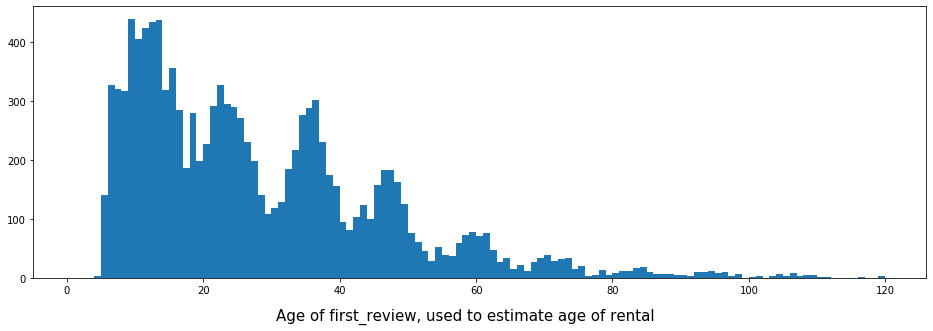

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (16, 5)
txt = 'Age of first_review, used to estimate age of rental'
plt.figtext(.5, .01, txt, ha='center', fontsize=15)
bin_edges = np.arange(1, 120+1, 1)
plt.hist(data=df_listings, x='age_months', bins=bin_edges);

A histogram of the age of first_reviews does not provide a whole lot of insight, other than the business is seasonal. Using intuition and a little domain knowledge, we can say somewhat arbitrarily that if the first_review is less than 12 months old, the property is still in its 'trial period'.  This choice will also allow us to safely use the number_of_reviews_ltm field.  (LTM stands for 'last twelve months'.)

In [21]:
add_age_column(df_b_listings)
add_age_column(df_s_listings)

min_age = 12
df_b_listings = df_b_listings[df_b_listings.age_months >= min_age]
df_s_listings = df_s_listings[df_s_listings.age_months >= min_age]
df_listings = df_b_listings.append(df_s_listings)
df_listings = prune_listings(df_listings)

Raw  : (10015, 27)
Clean: (9645, 27)


### What duration of rental is most common?

Even in its simplified form, this question can't be answered directly.  But we know the values are bounded by minimum and maximum nights, so this value is bounded.  Of course, in most cases there is no upper bound, so really we can only look at the minimum.

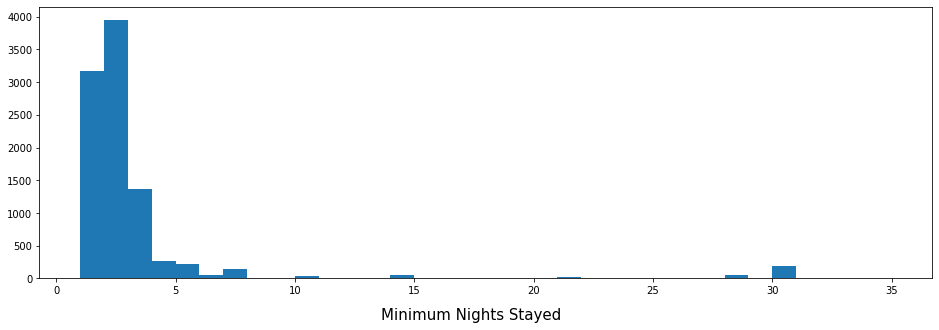

In [22]:
plt.rcParams["figure.figsize"] = (16, 5)
txt = 'Minimum Nights Stayed'
plt.figtext(.5, .01, txt, ha='center', fontsize=15)
bin_edges = np.arange(1, 35+1, 1)
plt.hist(data=df_listings, x='minimum_nights', bins=bin_edges);

The curve is (almost) bimodal.  The vast majority of rooms have a minimum of 1 week or less, (hence the 'BnB' in 'AirBnB',) with a small lump at 30 days.

The most common minimum is 2 nights.  This might seem a little surprising at first, but in a well-established industry such as this, there are generally reasons for things.

### Which locations are most popular?

In [23]:
boston_downtown = (42.354065, -71.054787)
seattle_downtown = (47.607792, -122.334625)  # Wow, Seattle is 5° further north!

# calculate distance in nautical miles
def as_the_crow_flies(lat1, long1, lat2, long2):
    a = lat2 - lat1
    b = long2 - long1
    deg = (a**2 + b**2)**.5
    dist = 60 * deg
    return dist

# convert distance
df_b_listings['dist_downtown'] = as_the_crow_flies(boston_downtown[0], boston_downtown[1],
                                                   df_b_listings.latitude, df_b_listings.longitude) 
df_s_listings['dist_downtown'] = as_the_crow_flies(seattle_downtown[0], seattle_downtown[1],
                                                   df_s_listings.latitude, df_s_listings.longitude)
df_listings = df_b_listings.append(df_s_listings)
df_listings = prune_listings(df_listings)

Raw  : (10015, 28)
Clean: (9645, 28)


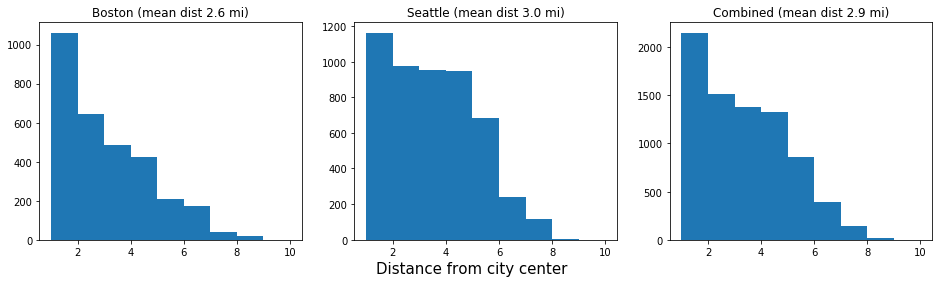

In [24]:
plt.rcParams["figure.figsize"] = (16, 4)
txt = 'Distance from city center'
plt.figtext(.5, .01, txt, ha='center', fontsize=15)
bin_edges = np.arange(1, 10+1, 1)
ax = plt.subplot(1, 3, 1)
ax.hist(data=df_b_listings, x='dist_downtown', bins=bin_edges)
ax.set_title(f'Boston (mean dist {df_b_listings.dist_downtown.mean():.1f} mi)')
ax = plt.subplot(1, 3, 2)
ax.hist(data=df_s_listings, x='dist_downtown', bins=bin_edges)
ax.set_title(f'Seattle (mean dist {df_s_listings.dist_downtown.mean():.1f} mi)')
ax = plt.subplot(1, 3, 3)
ax.hist(data=df_listings, x='dist_downtown', bins=bin_edges)
ax.set_title(f'Combined (mean dist {df_listings.dist_downtown.mean():.1f} mi)');

There are many landmarks we could choose, but proximity to 'downtown' (as defined by Bing maps) is probably good enough.  A more detailed investigation might include proximity to other attractions, such as universities or tourist attractions.

Most established Airbnb rentals are within 5 miles of the city center.  Boston is more compact, so it's not surprising that the rental units are clustered more tightly.

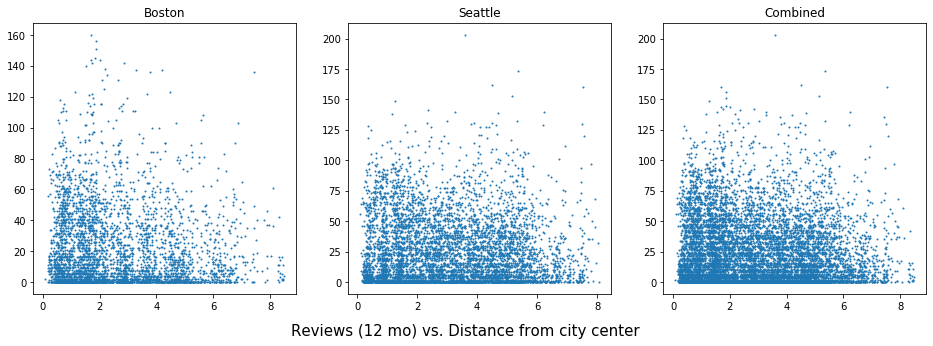

In [25]:
plt.rcParams["figure.figsize"] = (16, 5)
txt = 'Reviews (12 mo) vs. Distance from city center'
plt.figtext(.5, .01, txt, ha='center', fontsize=15)
bin_edges = np.arange(1, 10+1, 1)
ax = plt.subplot(1, 3, 1)
ax.scatter(data=df_b_listings, x='dist_downtown', y='number_of_reviews_ltm', s=1)
ax.set_title(f'Boston')
ax = plt.subplot(1, 3, 2)
ax.scatter(data=df_s_listings, x='dist_downtown', y='number_of_reviews_ltm', s=1)
ax.set_title(f'Seattle')
ax = plt.subplot(1, 3, 3)
ax.scatter(data=df_listings, x='dist_downtown', y='number_of_reviews_ltm', s=1)
ax.set_title(f'Combined');

Most rentals are near the city center, so naturally we expect to see more reviews towards downtown.  But, it seems that the units farther away generate plenty of reviews as well, including many of the highest performing properties.

### What type of accomodation is most common?

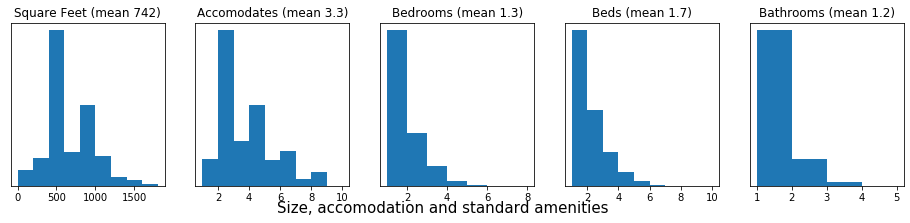

In [26]:
plt.rcParams["figure.figsize"] = (16, 3)
txt = 'Size, accomodation and standard amenities'
plt.figtext(.5, .0, txt, ha='center', fontsize=15)
bin_edges = np.arange(1, 2000+1, 200)
ax = plt.subplot(1, 5, 1)
ax.hist(data=df_listings, x='square_feet', bins=bin_edges)
ax.set_yticks([], [])
ax.set_title(f'Square Feet (mean {df_listings.square_feet.mean():.0f})')
bin_edges = np.arange(1, 10+1, 1)
ax = plt.subplot(1, 5, 2)
ax.hist(data=df_listings, x='accommodates', bins=bin_edges)
ax.set_yticks([], [])
ax.set_title(f'Accomodates (mean {df_listings.accommodates.mean():.1f})')
bin_edges = np.arange(1, 8+1, 1)
ax = plt.subplot(1, 5, 3)
ax.hist(data=df_listings, x='bedrooms', bins=bin_edges)
ax.set_yticks([], [])
ax.set_title(f'Bedrooms (mean {df_listings.bedrooms.mean():.1f})')
bin_edges = np.arange(1, 10+1, 1)
ax = plt.subplot(1, 5, 4)
ax.hist(data=df_listings, x='beds', bins=bin_edges)
ax.set_yticks([], [])
ax.set_title(f'Beds (mean {df_listings.beds.mean():.1f})');
bin_edges = np.arange(1, 5+1, 1)
ax = plt.subplot(1, 5, 5)
ax.hist(data=df_listings, x='bathrooms', bins=bin_edges)
ax.set_yticks([], [])
ax.set_title(f'Bathrooms (mean {df_listings.bathrooms.mean():.1f})');

The mean rental size is 742 sq ft, with the most common size being around 500 sq ft.

The most common rental accomodates 3 people.  Yet, the most common rental also has a single bedroom with a single bed.

The most common rental has a single bathroom, which would be logical for a 500 sq ft, 1-bedroom apartment.


### Which locations/types of properties bring in the largest rent?

In [27]:
df_b_listings.price = df_b_listings.price.str.replace('$', '').str.replace(',', '').astype(float)
df_b_listings.weekly_price = df_b_listings.weekly_price.str.replace('$', '').str.replace(',', '').astype(float)
df_b_listings.monthly_price = df_b_listings.monthly_price.str.replace('$', '').str.replace(',', '').astype(float)
df_s_listings.price = df_s_listings.price.str.replace('$', '').str.replace(',', '').astype(float)
df_s_listings.weekly_price = df_s_listings.weekly_price.str.replace('$', '').str.replace(',', '').astype(float)
df_s_listings.monthly_price = df_s_listings.monthly_price.str.replace('$', '').str.replace(',', '').astype(float)
df_listings = df_b_listings.append(df_s_listings)
df_listings = prune_listings(df_listings)
# prune the high-end outliers as well
df_listings = df_listings[df_listings.price <= 800]

Raw  : (10015, 28)
Clean: (9645, 28)


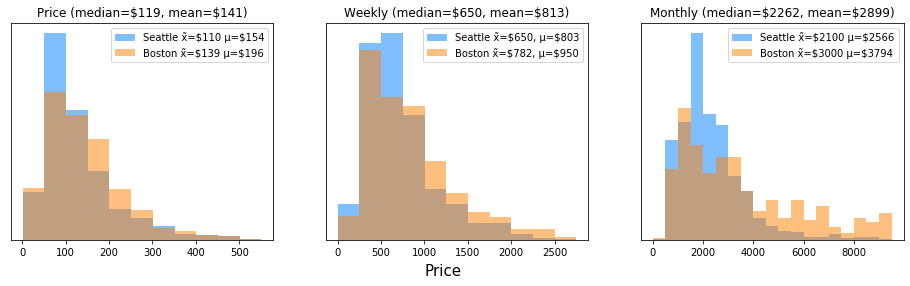

In [28]:
plt.rcParams["figure.figsize"] = (16, 4)
plt.figtext(.5, .001, 'Price', ha='center', fontsize=15)
bin_edges = np.arange(1, 600+1, 50)
ax = plt.subplot(1, 3, 1)
s = ax.hist(data=df_s_listings, x='price', bins=bin_edges, density=True, fc=(0,.5,1,.5))
b = ax.hist(data=df_b_listings, x='price', bins=bin_edges, density=True, fc=(1,.5,0,.5))
ax.set_title(f'Price (median=\${df_listings.price.median():.0f}, mean=\${df_listings.price.mean():.0f})')
ax.set_yticks([], [])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, 
          labels=[f'Seattle x̃=\${df_s_listings.price.median():.0f} μ=\${df_s_listings.price.mean():.0f}',
                  f'Boston x̃=\${df_b_listings.price.median():.0f} μ=\${df_b_listings.price.mean():.0f}']);

bin_edges = np.arange(1, 3000+1, 250)
ax = plt.subplot(1, 3, 2)
s = ax.hist(data=df_s_listings, x='weekly_price', bins=bin_edges, density=True, fc=(0,.5,1,.5))
b = ax.hist(data=df_b_listings, x='weekly_price', bins=bin_edges, density=True, fc=(1,.5,0,.5))
ax.set_title(f'Weekly (median=\${df_listings.weekly_price.median():.0f}, mean=\${df_listings.weekly_price.mean():.0f})')
ax.set_yticks([], [])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, 
          labels=[f'Seattle x̃=\${df_s_listings.weekly_price.median():.0f}, μ=\${df_s_listings.weekly_price.mean():.0f}',
                  f'Boston x̃=\${df_b_listings.weekly_price.median():.0f}, μ=\${df_b_listings.weekly_price.mean():.0f}']);

bin_edges = np.arange(1, 10000+1, 500)
ax = plt.subplot(1, 3, 3)
s = ax.hist(data=df_s_listings, x='monthly_price', bins=bin_edges, density=True, fc=(0,.5,1,.5))
b = ax.hist(data=df_b_listings, x='monthly_price', bins=bin_edges, density=True, fc=(1,.5,0,.5))
ax.set_title(f'Monthly (median=\${df_listings.monthly_price.median():.0f}, mean=\${df_listings.monthly_price.mean():.0f})')
ax.set_yticks([], [])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, 
          labels=[f'Seattle x̃=\${df_s_listings.monthly_price.median():.0f} μ=\${df_s_listings.monthly_price.mean():.0f}',
                  f'Boston x̃=\${df_b_listings.monthly_price.median():.0f} μ=\${df_b_listings.monthly_price.mean():.0f}']);

Prices in Boston and Seattle are not an apples-to-apples comparison, so these are graphed separately.  Boston is more expensive than Seattle, which is to be expected.  Real estate prices in general have a positive skew, and these plots are no exception.  The median price is more commonly used for this reason.

Boston skews further to the right than Seattle, and this difference becomes more pronounced as the duration of the stay increases.  The monthly rate for Boston has a strong positive skew.  This bears further investigation.  For example, there could be local taxes or ordinances driving this.

In [29]:
# The square_feet data seems to be especially dirty, so do a little extra cleaning for that plot
df_square_feet = df_listings[df_listings.square_feet > 25]
df_square_feet = df_square_feet[df_square_feet.price / df_square_feet.square_feet > 0.10]

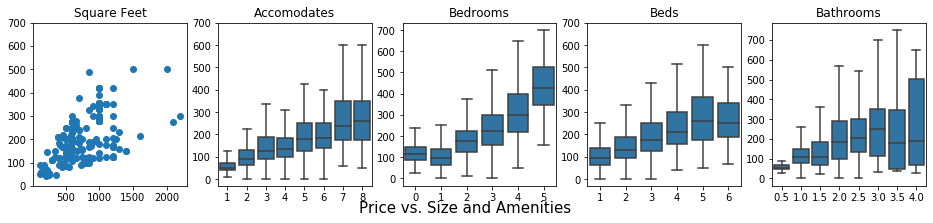

In [30]:
import seaborn as sb
plt.rcParams["figure.figsize"] = (16, 3)
txt = 'Price vs. Size and Amenities'
plt.figtext(.5, .0, txt, ha='center', fontsize=15)
base_color = sb.color_palette()[0]
ax = plt.subplot(1, 5, 1)
ax.scatter(data=df_square_feet, x='square_feet', y='price')
y = np.arange(0, 800, 100)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_title(f'Square Feet')
ax = plt.subplot(1, 5, 2)
sb.boxplot(data=df_listings, x='accommodates', y='price', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 800, 100)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Accomodates')
ax = plt.subplot(1, 5, 3)
sb.boxplot(data=df_listings, x='bedrooms', y='price', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 800, 100)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Bedrooms')
ax = plt.subplot(1, 5, 4)
sb.boxplot(data=df_listings, x='beds', y='price', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 800, 100)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Beds')
ax = plt.subplot(1, 5, 5)
sb.boxplot(data=df_listings, x='bathrooms', y='price', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 800, 100)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Bathrooms');

The price has a generally a positive correlation between square footage, number people acommodated, and bedrooms.  It stands to reason that a larger property will cost more.  However, beds and bathrooms reach a peak value and then actually drop.

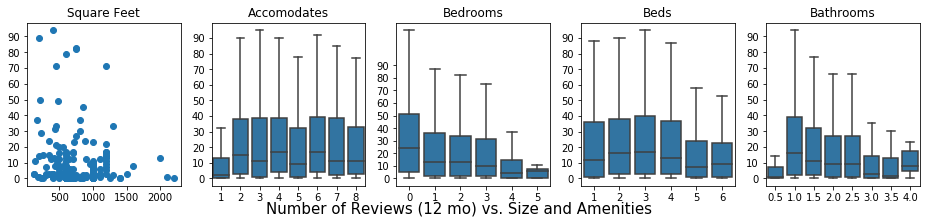

In [31]:
import seaborn as sb
plt.rcParams["figure.figsize"] = (16, 3)
txt = 'Number of Reviews (12 mo) vs. Size and Amenities'
plt.figtext(.5, .0, txt, ha='center', fontsize=15)
base_color = sb.color_palette()[0]
ax = plt.subplot(1, 5, 1)
ax.scatter(data=df_square_feet, x='square_feet', y='number_of_reviews_ltm')
y = np.arange(0, 100, 10)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_title(f'Square Feet')
ax = plt.subplot(1, 5, 2)
sb.boxplot(data=df_listings, x='accommodates', y='number_of_reviews_ltm', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 100, 10)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Accomodates')
ax = plt.subplot(1, 5, 3)
sb.boxplot(data=df_listings, x='bedrooms', y='number_of_reviews_ltm', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 100, 10)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Bedrooms')
ax = plt.subplot(1, 5, 4)
sb.boxplot(data=df_listings, x='beds', y='number_of_reviews_ltm', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 100, 10)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Beds')
ax = plt.subplot(1, 5, 5)
sb.boxplot(data=df_listings, x='bathrooms', y='number_of_reviews_ltm', showfliers=False, ax=ax, color=base_color)
y = np.arange(0, 100, 10)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Bathrooms');

A larger property will only bring in more money if you're able to rent it out.  We don't have rental histories, but we can roughly approximate it using the number of reviews in the last year.  Although a little abstract, this set of graphs shows what customers are actually renting.

Generally speaking, smaller properties with fewer bedrooms and bathrooms are more popular.  A studio apartments with a single full bathroom is the most popular.

Surprisingly, the number of occupants and number of beds are pretty flat graphs, with the most popular having 3 beds.

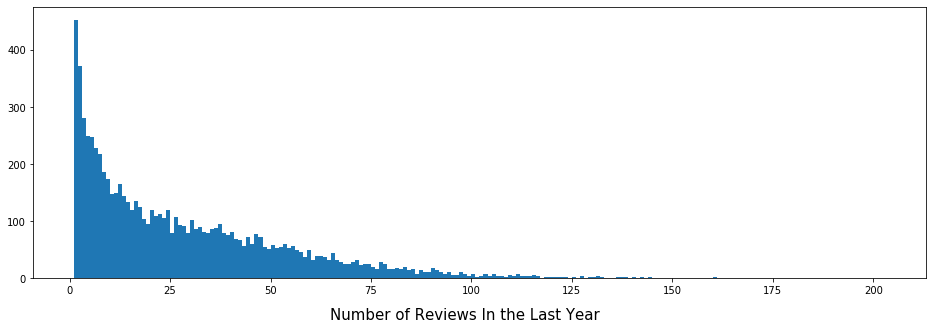

In [32]:
plt.rcParams["figure.figsize"] = (16, 5)
txt = 'Number of Reviews In the Last Year'
plt.figtext(.5, .01, txt, ha='center', fontsize=15)
bin_edges = np.arange(1, df_listings.number_of_reviews_ltm.max()+1, 1)
plt.hist(data=df_listings, x='number_of_reviews_ltm', bins=bin_edges);

Also noteworthy is that the number of reviews in the last year is roughly a power distribution.  Most properties receive few reviews, but a few properties receive very many.

# CRISP-DM step 6